In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import prepare3

import acquire2
import inflection
import matplotlib.ticker as mtick # For specifying the axes tick format 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from scipy import stats #statistical tests

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df = acquire2.get_telco_data(use_cache = True)
df.head()

Using cached csv


,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,2,1,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,DSL,One year,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Month-to-month,Mailed check
2,1,1,2,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Fiber optic,Month-to-month,Electronic check
3,1,1,2,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Fiber optic,Month-to-month,Electronic check
4,2,1,2,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Fiber optic,Month-to-month,Mailed check


#### Determine if certain columns should be dropped:
- Will use a prepare file to drop:
    - payment_type_id
    - contract_type_id
    - internet_service_type_id

In [3]:
telco_df = prepare3.prep_telco_data(df)
train, test, split = telco_df
train.head().T

customer_id,8331-ZXFOE,2790-XUYMV,7107-UBYKY,3373-YZZYM,8883-GRDWQ
gender,Female,Male,Female,Male,Male
senior_citizen,No,No,No,No,Yes
partner,No,No,Yes,Yes,No
dependents,No,Yes,Yes,Yes,No
tenure,58,71,35,1,20
phone_service,Yes,Yes,Yes,Yes,Yes
multiple_lines,Yes,Yes,Yes,No,No
online_security,Yes,Yes,No,No,Yes
online_backup,Yes,Yes,No,No,No
device_protection,Yes,No,No,No,No


#### Determine if it would be valuable to bin some numeric columns:

- Binning tenure, monthly charges, and total charges by distance could provide some valuable data smoothing for visualizations 
- Looking at the ranges, the most significant is total charges, but won't be turning into categorical, will remain unbinned.

In [4]:
train.tenure.min(), train.tenure.max()

(1, 72)

In [5]:
train.tenure.max() - train.tenure.min()

71

In [6]:
train.monthly_charges.min(), train.monthly_charges.max()

(18.25, 118.65)

In [7]:
train.monthly_charges.max() - train.monthly_charges.min()

100.4

In [8]:
train.total_charges.min(), train.total_charges.max()

(18.85, 8594.4)

In [9]:
train.total_charges.max() - train.total_charges.min()

8575.55

#### Data Binning (total charges)

(array([1051.,  458.,  371.,  281.,  203.,  167.,  155.,  134.,  126.,
         130.,  118.,  131.,  102.,  112.,  100.,   95.,   68.,   60.,
          51.,   24.]),
 array([  18.85  ,  447.6275,  876.405 , 1305.1825, 1733.96  , 2162.7375,
        2591.515 , 3020.2925, 3449.07  , 3877.8475, 4306.625 , 4735.4025,
        5164.18  , 5592.9575, 6021.735 , 6450.5125, 6879.29  , 7308.0675,
        7736.845 , 8165.6225, 8594.4   ]),
 <BarContainer object of 20 artists>)

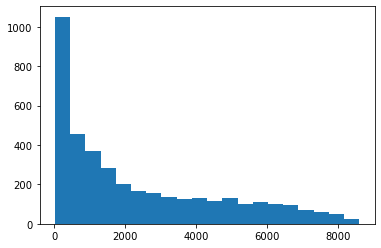

In [10]:
#pd.qcut(df['math score'], q=4)

#tc_bins = pd.qcut(train['total_charges'], q = 20, precision = 0)

plt.hist(train['total_charges'], bins = 20)

#### Determine if it would be valuable to combine multiple columns into one:
- Earlier analysis suggested a multicoliniearity issue may arise in services related to phone and internet when getting dummy variables, used prepare file to resolve those issues and subsequently reduce extraneous columns from forming.


In [11]:
train.describe()

,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,senior_citizen_encoded,...,tech_support_yes,streaming_tv_yes,streaming_movies_yes,contract_type_one_year,contract_type_two_year,internet_service_type_fiber_optic,internet_service_type_none,payment_type_credit_card,payment_type_electronic_check,payment_type_mailed_check
count,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,...,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000
mean,32.775210,64.805131,2316.775641,0.498095,0.485141,0.302769,0.905258,0.590297,0.265685,0.161290,...,0.289307,0.386335,0.391415,0.207010,0.243078,0.437389,0.220218,0.227330,0.327407,0.226314
std,24.709604,30.294804,2284.984394,0.500060,0.499843,0.459514,0.292896,0.491841,0.441753,0.367845,...,0.453498,0.486971,0.488129,0.405215,0.428997,0.496127,0.414447,0.419161,0.469327,0.418498
min,1.000000,18.250000,18.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,34.700000,396.100000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,70.250000,1414.800000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,56.000000,90.300000,3893.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,72.000000,118.650000,8594.400000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Separate  (unencoded) categorical columns

In [12]:
cat_cols = ['gender', 
            'senior_citizen', 
            'partner', 
            'dependents', 
            'phone_service', 
            'multiple_lines', 
            'online_security', 
            'online_backup', 
            'device_protection', 
            'tech_support', 
            'streaming_tv', 
            'streaming_movies', 
            'paperless_billing', 
            'churn', 
            'internet_service_type', 
            'contract_type', 
            'payment_type']

#### Plot numeric columns
num_cols = train.columns[[train[col].dtype == 'float64' for col in train.columns]]
for col in num_cols:
    plt.hist(train[col])
    plt.title(col)
    plt.show()
    plt.boxplot(train[col])
    plt.title(col)
    plt.show()


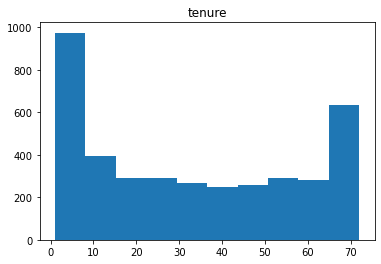

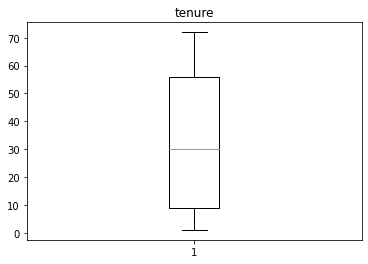

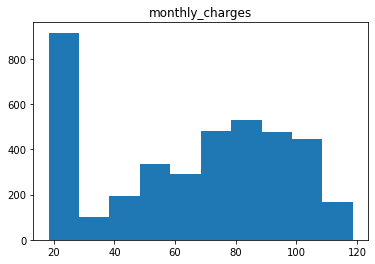

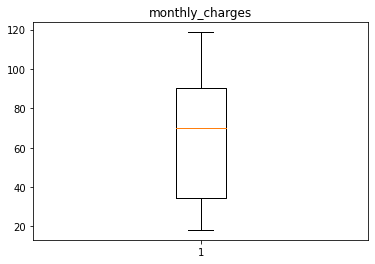

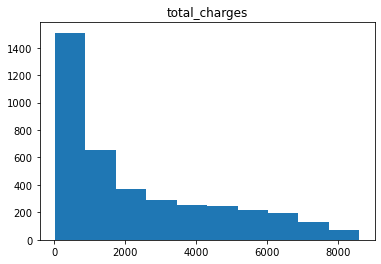

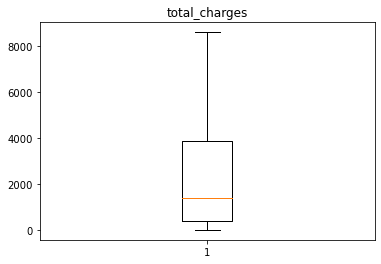

In [13]:
#plot numeric columns
num_cols = ['tenure', 'monthly_charges', 'total_charges']

for col in num_cols:
    plt.hist(train[col])
    plt.title(col)
    plt.show()
    plt.boxplot(train[col])
    plt.title(col)
    plt.show()


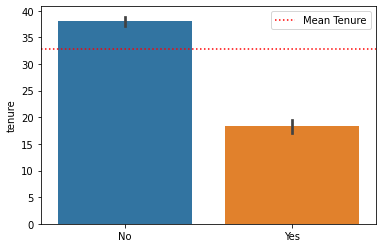

In [14]:
sns.barplot(x = 'churn', y = 'tenure', data = train)
mean_tenure = train.tenure.mean()
plt.axhline(mean_tenure, label = "Mean Tenure", color = 'red', linestyle = 'dotted')
plt.xlabel('')
plt.legend()
plt.show()

<AxesSubplot:xlabel='tenure', ylabel='monthly_charges'>

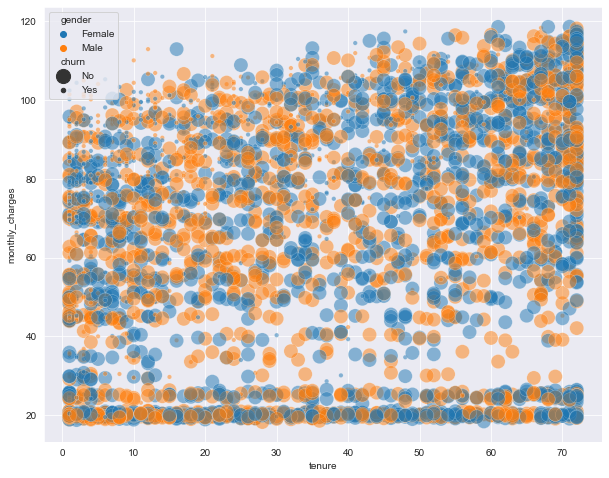

In [15]:
plt.figure(figsize = (10, 8))
sns.set_style("darkgrid")

sns.scatterplot(data = train, 
                x = 'tenure', 
                y = 'monthly_charges', 
                size = 'churn', 
                hue = 'gender', 
                #palette = "viridis", 
                edgecolors = "black", 
                alpha = 0.5, 
                sizes = (20, 200))

<AxesSubplot:xlabel='gender', ylabel='monthly_charges'>

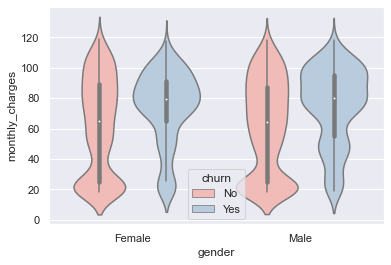

In [16]:
sns.set(style = 'darkgrid')

sns.violinplot(data = train,
               x = 'gender',
               y = 'monthly_charges',
               hue = 'churn', palette = "Pastel1")

### Takeaways:
- Visually, churn and gender seem to hold little statistical significance, will try another visual and Chi Square test

### Demographic features and Churn

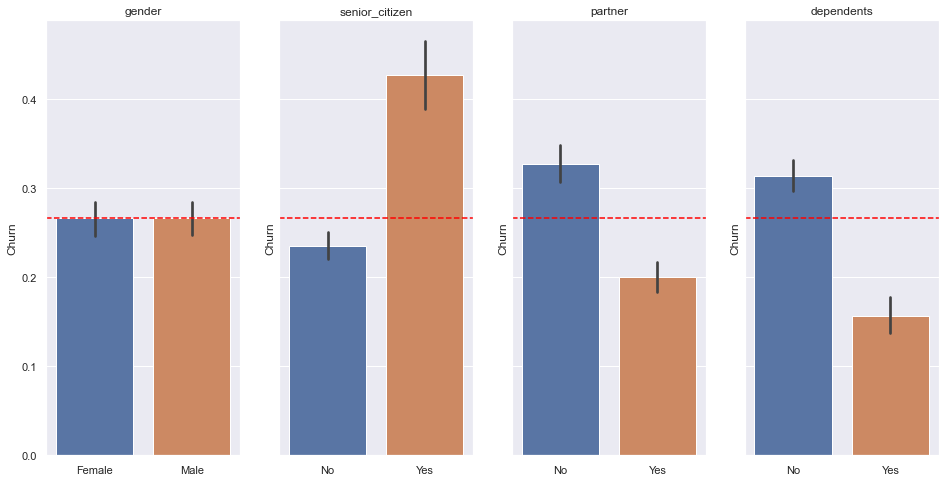

In [19]:
features = ['gender', 'senior_citizen', 'partner', 'dependents']

_, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 8), sharey = True)
for i, feature in enumerate (features):
    sns.barplot(feature, 'churn_encoded', data = train, ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn')
    ax[i].set_title(feature)
    ax[i].axhline(train.churn_encoded.mean(), ls = '--', color = 'red')

#### Takeaways:
Customers with partners and dependents seem to have a negative correlation with churn. Customers that are senior citizens seem to have a positive correlation with churn. Gender still appears to have no correlation with churn.

#### Statistical Tests: Chi Square:

In [31]:
null = "gender and churn are independent."
alt = "there is a relationship between gender and churn."
α = 0.5

#setup crosstab
observed = pd.crosstab(train.churn, train.gender)

chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

if p < α:
    print('Reject the null hypothesis which states,', null)
    print('Evidence suggests that', alt)
else:
    print('Fail to reject the null:', null)
    print('There is insufficient evidence to support the claim that,', alt)

Fail to reject the null: gender and churn are independent.
There is insufficient evidence to support the claim that, there is a relationship between gender and churn.


In [32]:
null = "seniority and churn are independent."
alt = "there is a relationship between seniority and churn."
α = 0.5

#setup crosstab
observed = pd.crosstab(train.churn, train.senior_citizen)

chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

if p < α:
    print('Reject the null hypothesis which states,', null)
    print('Evidence suggests that', alt)
else:
    print('Fail to reject the null:', null)
    print('There is insufficient evidence to support the claim that,', alt)

Reject the null hypothesis which states, seniority and churn are independent.
Evidence suggests that there is a relationship between seniority and churn.


In [21]:
null = "being partnered and churn are independent."
alt = "there is a relationship between being partnered and churn."
α = 0.5

#setup crosstab
observed = pd.crosstab(train.churn, train.partner)

chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

if p < α:
    print('Reject the null hypothesis which states,', null)
    print('Evidence suggests that', alt)
else:
    print('Fail to reject the null:', null)
    print('There is insufficient evidence to support the claim that,', alt)

Reject the null hypothesis which states, being partnered and churn are independent.
Evidence suggests that there is a relationship between being partnered and churn.


In [22]:
null = "having dependents and churn are independent."
alt = "there is a relationship between having dependents and churn."
α = 0.5

#setup crosstab
observed = pd.crosstab(train.churn, train.dependents)

chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

if p < α:
    print('Reject the null hypothesis which states,', null)
    print('Evidence suggests that', alt)
else:
    print('Fail to reject the null:', null)
    print('There is insufficient evidence to support the claim that,', alt)

Reject the null hypothesis which states, having dependents and churn are independent.
Evidence suggests that there is a relationship between having dependents and churn.


#### Takeaways:
- According to statistical tests:
    - Gender and churn are independent
    - Seniority and churn are not independent
    - Being partnered and churn are not independent
    - Having dependents and churn are not independent

### Payment features and Churn

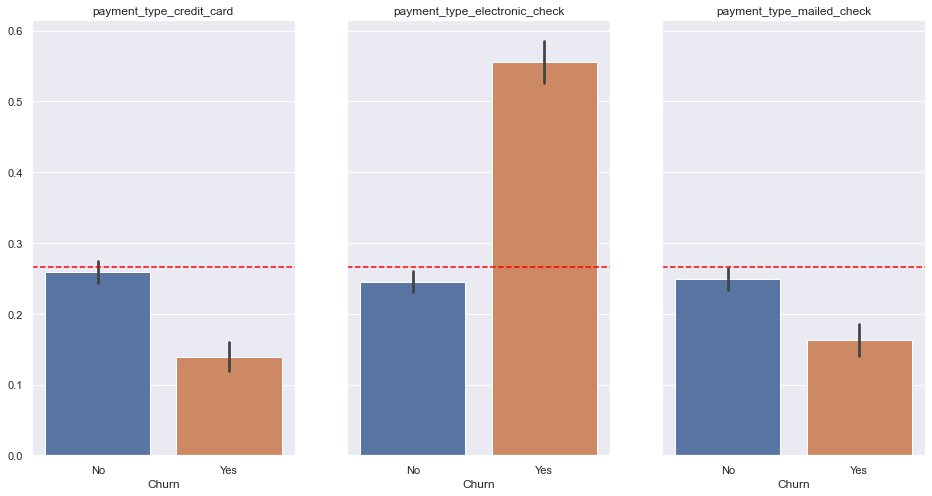

In [17]:
features = ['payment_type_credit_card', 'payment_type_electronic_check', 'payment_type_mailed_check']

_, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 8), sharey = True)
for i, feature in enumerate (features):
    sns.barplot('churn', feature, data = train, ax = ax[i])
    ax[i].set_xlabel('Churn')
    ax[i].set_ylabel('')
    ax[i].set_title(feature)
    ax[i].axhline(train.churn_encoded.mean(), ls = '--', color = 'red')

#### Takeaways:

Customers that pay with an electronic check appear to have an above average churn probability, while other payment methods seem to have negative correlation.

#### Statistical Test: Chi Square:

In [35]:
null = "credit card payments and churn are independent."
alt = "there is a relationship between credit card payments and churn."
α = 0.5

#setup crosstab
observed = pd.crosstab(train.churn, train.payment_type_credit_card)

chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

if p < α:
    print('Reject the null hypothesis which states,', null)
    print('Evidence suggests that,', alt)
else:
    print('Fail to reject the null:', null)
    print('There is insufficient evidence to support the claim that,', alt)

Reject the null hypothesis which states, credit card payments and churn are independent.
Evidence suggests that, there is a relationship between credit card payments and churn.


In [36]:
null = "e-check payment type and churn are independent."
alternative = "there is a relationship between churn and e-check payment type"
α = 0.5

#setup crosstab
observed = pd.crosstab(train.churn, train.payment_type_electronic_check)

chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

if p < α:
    print('Reject the null hypothesis which states,', null)
    print('Evidence suggests that,', alternative)
else:
    print('Fail to reject the null:', null)
    print('There is insufficient evidence to support the claim that,', alt)

Reject the null hypothesis which states, e-check payment type and churn are independent.
Evidence suggests that, there is a relationship between churn and e-check payment type


In [37]:
null = "mailed check payments and churn are independent."
alt = "there is a relationship between mailed check payments and churn."
α = 0.5

#setup crosstab
observed = pd.crosstab(train.churn, train.payment_type_mailed_check)

chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

if p < α:
    print('Reject the null hypothesis which states,', null)
    print('Evidence suggests that,', alt)
else:
    print('Fail to reject the null:', null)
    print('There is insufficient evidence to support the claim that,', alt)

Reject the null hypothesis which states, mailed check payments and churn are independent.
Evidence suggests that, there is a relationship between mailed check payments and churn.


#### Takeaways:
   - Credit card payments and churn are not independent
   - Electronic check payments and churn are not independent
   - Mailed check payments and churn are not independent

---

---

In [23]:
#numerical vs. categorical
#what is the relationship between monthly charges and churn?



#subset data
retained = train[train.churn == 'No']
churned = train[train.churn == 'Yes']


#check variance of two groups
retained.monthly_charges.var(), churned.monthly_charges.var()

(982.7932072180829, 604.8633241695393)

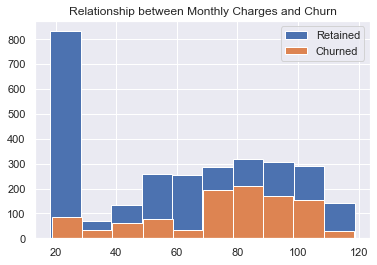

In [24]:
plt.title("Relationship between Monthly Charges and Churn")
plt.hist(retained.monthly_charges, label = 'Retained')
plt.hist(churned.monthly_charges, label = 'Churned')
plt.legend()
plt.show()

#### Takeaways:
There is a significant difference in the amount that retained and churn customers pay in monthly charges, the data doesn't follow a normal (bell-shaped) distribution.

#### Statistical Test: Mann-Whitney

In [25]:
#check medians to see if they are similar

train.groupby('churn')['monthly_charges'].median()

churn
No     64.50
Yes    79.85
Name: monthly_charges, dtype: float64

In [26]:
#since medians are dissimilar, use a one-sided Mann-Whitney

#null = 'the monthly charges of churned customers is less than or equal to the monthly charges of retained customers'
#alt = 'the monthly charges of churned customers is greater than the monthly charges of retain customers'

u, p = stats.mannwhitneyu(churned.monthly_charges, retained.monthly_charges, alternative = 'greater')

u, round(p,3)

(1883278.5, 0.0)

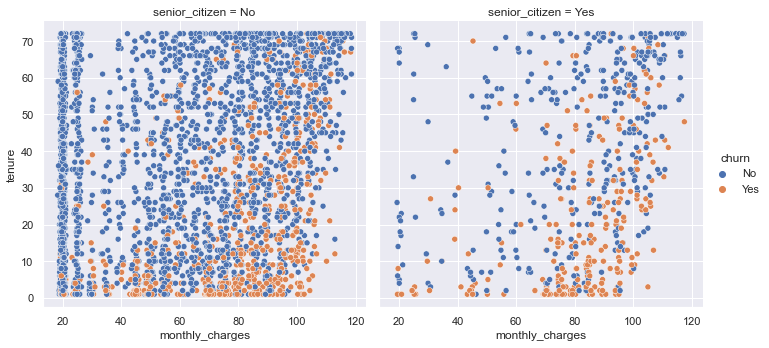

In [27]:
sns.relplot(data = train, 
            x = 'monthly_charges', 
            y = 'tenure', 
            hue = 'churn', 
            col = 'senior_citizen')

# Exercises:


What are your drivers of churn?

- Paying by e-check and seniority status are two drivers discovered during preliminary EDA.

Does it make sense to combine any features?
- Potentially, exploring internet service features combined and demographics combined may prove useful for further exploratory analysis.

Do you find any surprises?

- Seniority status (thusfar) is a major driver of churn, further analysis is necessary.

